In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from utility import *

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class coupling_layer(nn.Module):
    """
    Implements coupling layer:
    Forward transform (x = f(z)):
    x_1:d = z_1:d
    x_d+1:D = (z_d+1:D - \mu_d+1:D)*exp(-\alpha_d+1:D)
    
    Inverse transform (z = f^-1(x)):
    z_1:d = x_1:d
    z_d+1:D = x_d+1_D*exp(\alpha_d+1:D)+\mu_d+1:D
    
    d is a parameter here (although no choice in 2D case).
    
    Here we train using the inverse function.
    """
    def __init__(self, net):
        """
        Init net for parametrizing $\alpha$ and $\mu$.
        """
        super().__init__()
        self.net = net
        
    def forward(self, z):
        with torch.no_grad():
            z_1_d, z_d_D = torch.chunk(z, 2, dim=-1)
            outs = self.net(z_1_d)
            mu, alpha = torch.chunk(outs, 2, dim=-1)
            x_1_d = z_1_d
            x_d_D = (z_d_D-mu)*torch.exp(-alpha)
        x = torch.cat([x_1_d, x_d_D], dim=-1)
        return x    
    
    def inverse(self, x):
        x_1_d, x_d_D = torch.chunk(x, 2, dim=-1)
        outs = self.net(x_1_d)
        mu, alpha = torch.chunk(outs, 2, dim=-1)
        z_1_d = x_1_d
        z_d_D = x_d_D*torch.exp(alpha)+mu
        z = torch.cat([z_1_d, z_d_D], dim=-1)
        return z, alpha       
    
class CouplingFlow(nn.Module):
    """
    Now create the flow. Stack layers of transforms and forward.
    *Have to choose number of transforms, K.*
    *Have to choose d which is the number of variables that are left untouched in each layer (in 2d cases it can only be 2d)*
    """
    def __init__(self, dim, K, d=1):
        super().__init__()
        self.dim = dim
        self.d = d
        
        self.transform_layers = []
        for i in range(K):
            if i != K-1:
                self.transform_layers.append(coupling_layer(make_net(self.d)))
                self.transform_layers.append(permute_layer())
            else:
                self.transform_layers.append(coupling_layer(make_net(self.d)))
        
        self.model = nn.Sequential(*self.transform_layers)
        self.base_distr = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
        
    def forward(self, z, size=1):
        if size == 1:
            z = self.base_distr.rsample()
        else:
            z = self.base_distr.n_sample(size)
        
        for layer in self.transform_layers:
            z = layer(z)
            
        return z
    
    def inverse(self, x):
        log_det_J = torch.zeros(x.shape[0])
        
        for layer in reversed(self.model):
            x, alpha = layer.inverse(x)
            log_det_J += alpha.squeeze()
            
        
        log_prob_z0 = self.base_distr.log_prob(x)
        return x, -((log_prob_z0+log_det_J).mean())
        
    
def make_net(in_dim):
    net = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 2))
    return net

class permute_layer(nn.Module):
    """
    We need to permute the variables in between flow layers because otherwise some variables are never transformed.
    Permute layer inspired by reverse bijections in Didrik's notebook.
    The inverse returning two separate tensors is a hack to ensure that we consistently can unpack the correct number of vars.
    """
    def inverse(self, x):
        return x.flip(-1), x.new_zeros(x.shape[0])

    def forward(self, z):
        return z.flip(-1)

In [113]:
dim = 2
K = 5
batch_size= 64
epochs= 5000
lr = 0.0005

real_NVP = CouplingFlow(dim=dim, K=K)
dataset = Datasets("moons")
train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False)
loss_func = TrainingLoss(dim=dim)
optimiser = torch.optim.Adam(real_NVP.parameters(), lr=lr)

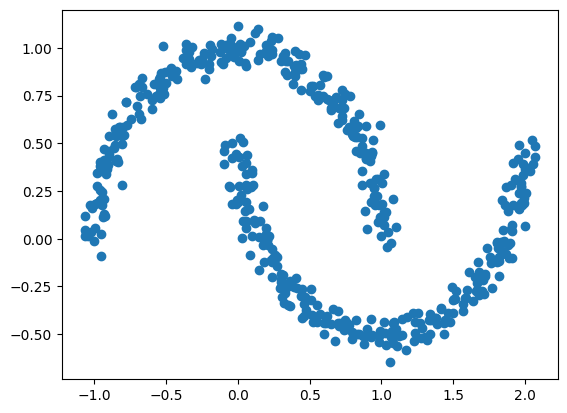

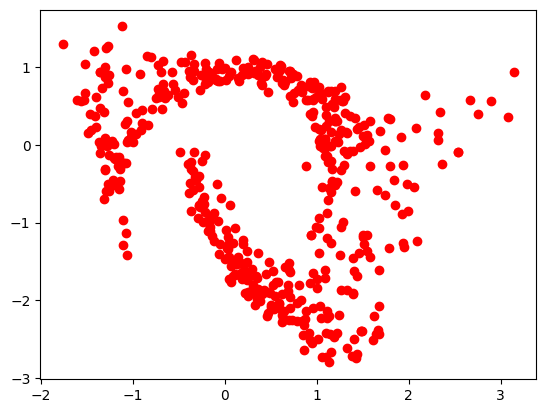

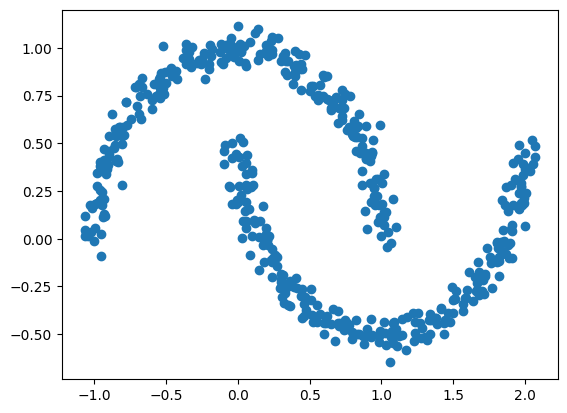

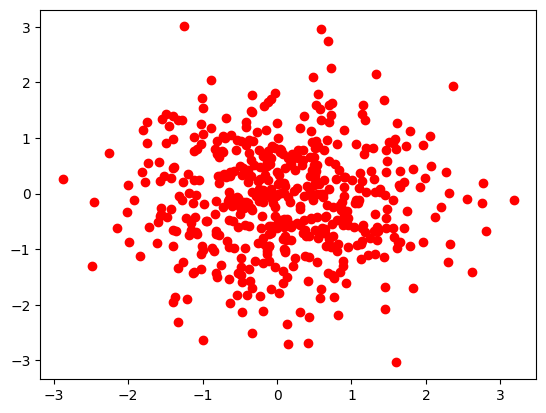

In [114]:
for i in range(epochs):
    z_list = []
    x_list = []
    for step, data in enumerate(train_loader):
        #Pass batch through flow.
        optimiser.zero_grad()
        z0, loss = real_NVP.inverse(data)
        z_list.append(z0)
        x_list.append(data)
        # Training step. 
        loss.backward()
        optimiser.step()
    if i == 0:
        x_list = torch.cat(x_list, 0)
        z_list = torch.cat(z_list, 0)
        plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
        plt.show()
        plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
        plt.show()
x_list = torch.cat(x_list, 0)
z_list = torch.cat(z_list, 0)
plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
plt.show()
plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
plt.show()

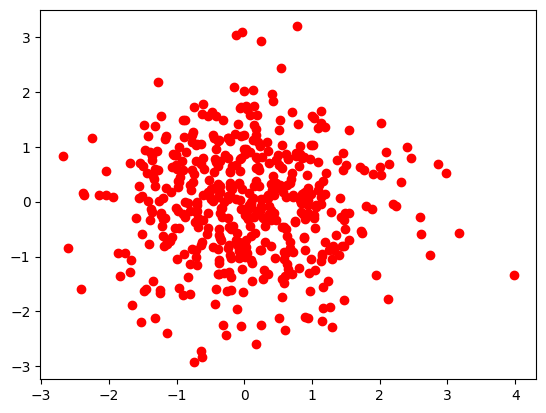

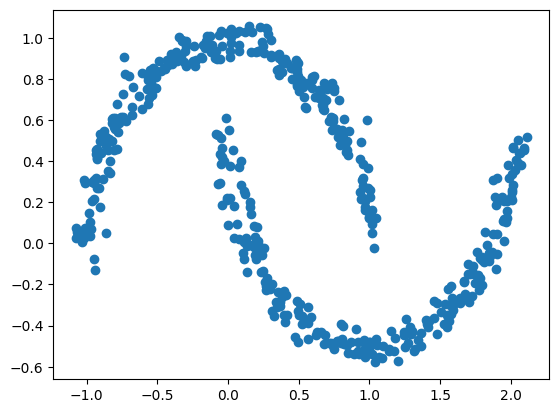

In [115]:
x_list = []
z_list = []
for i in range(500):
    sample_from_prior = real_NVP.base_distr.rsample()
    z_list.append(sample_from_prior.detach().numpy())
    x = real_NVP(sample_from_prior.unsqueeze(0))
    x_list.append(x.squeeze().detach().numpy())
plt.scatter(torch.Tensor(z_list)[:,0], torch.Tensor(z_list)[:,1], color="r")
plt.show()
plt.scatter(torch.Tensor(x_list)[:,0], torch.Tensor(x_list)[:,1])
plt.show()

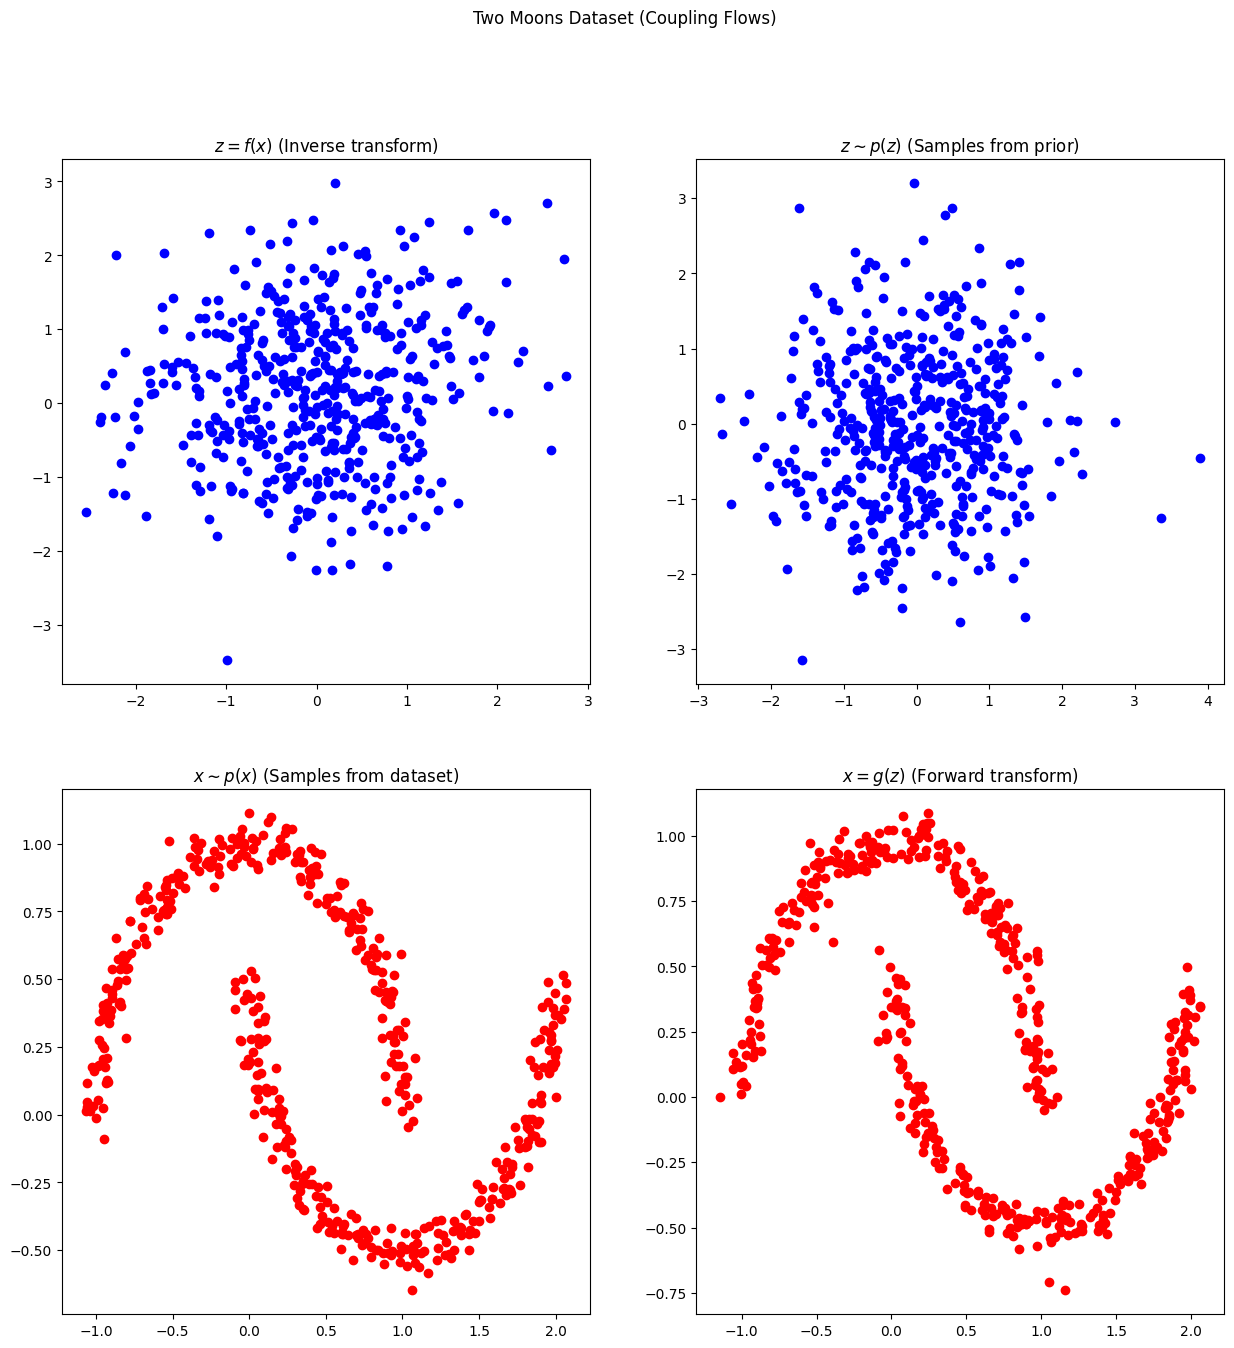

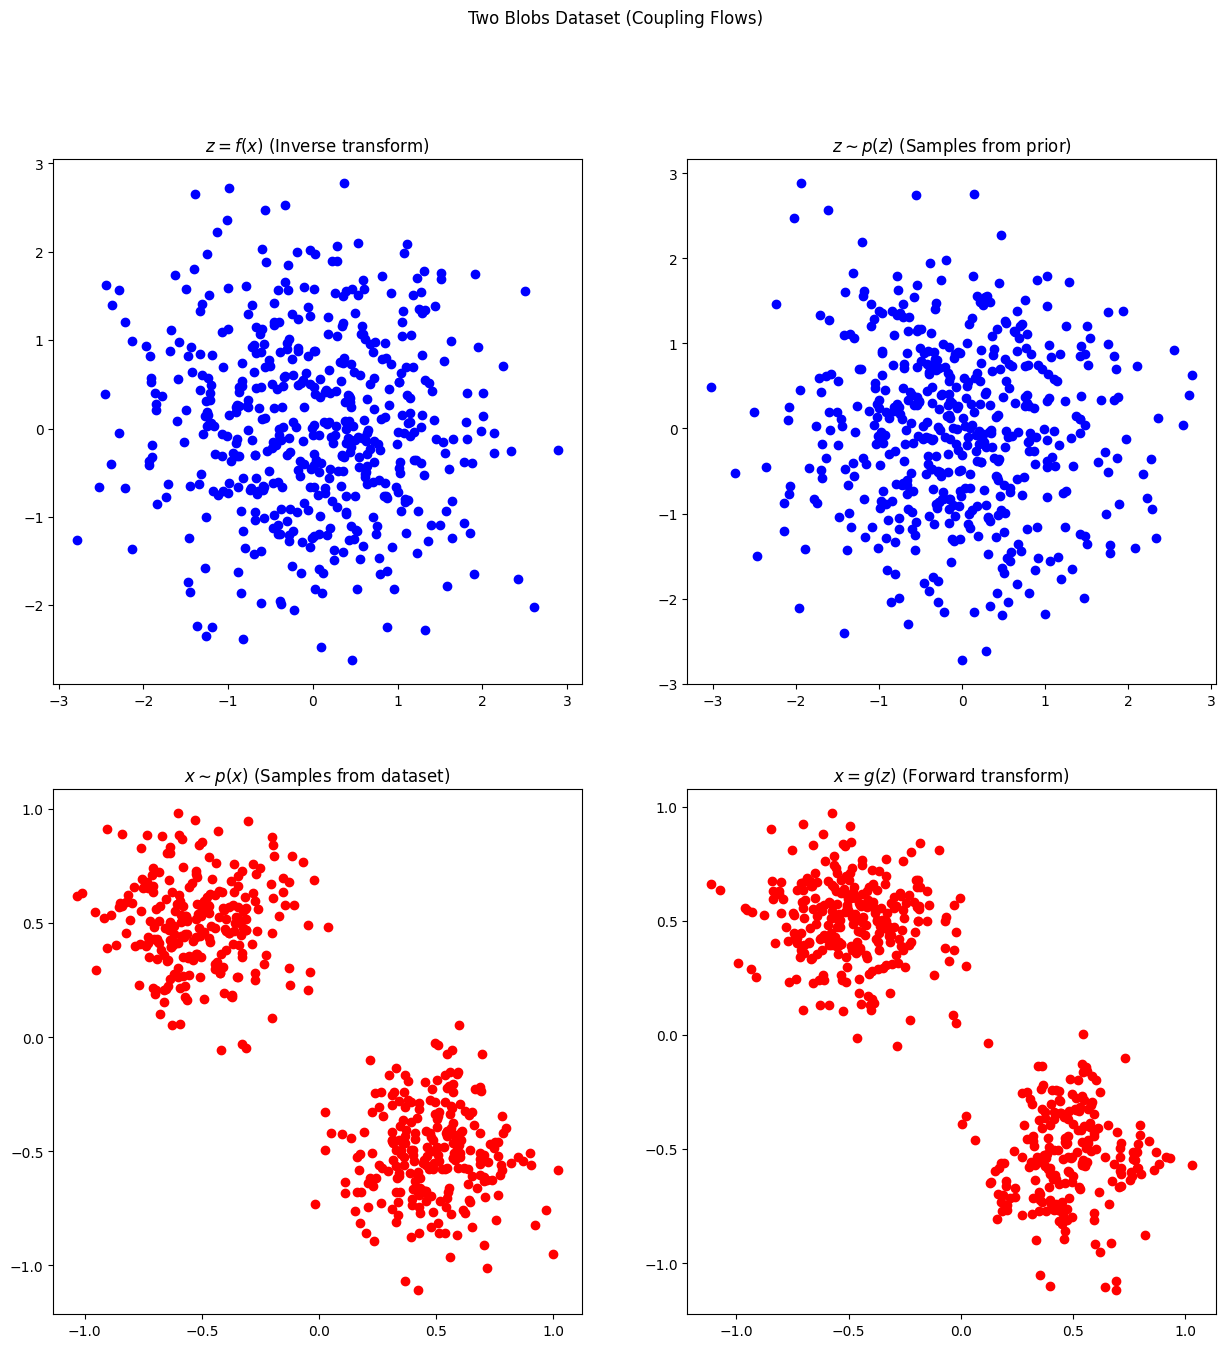

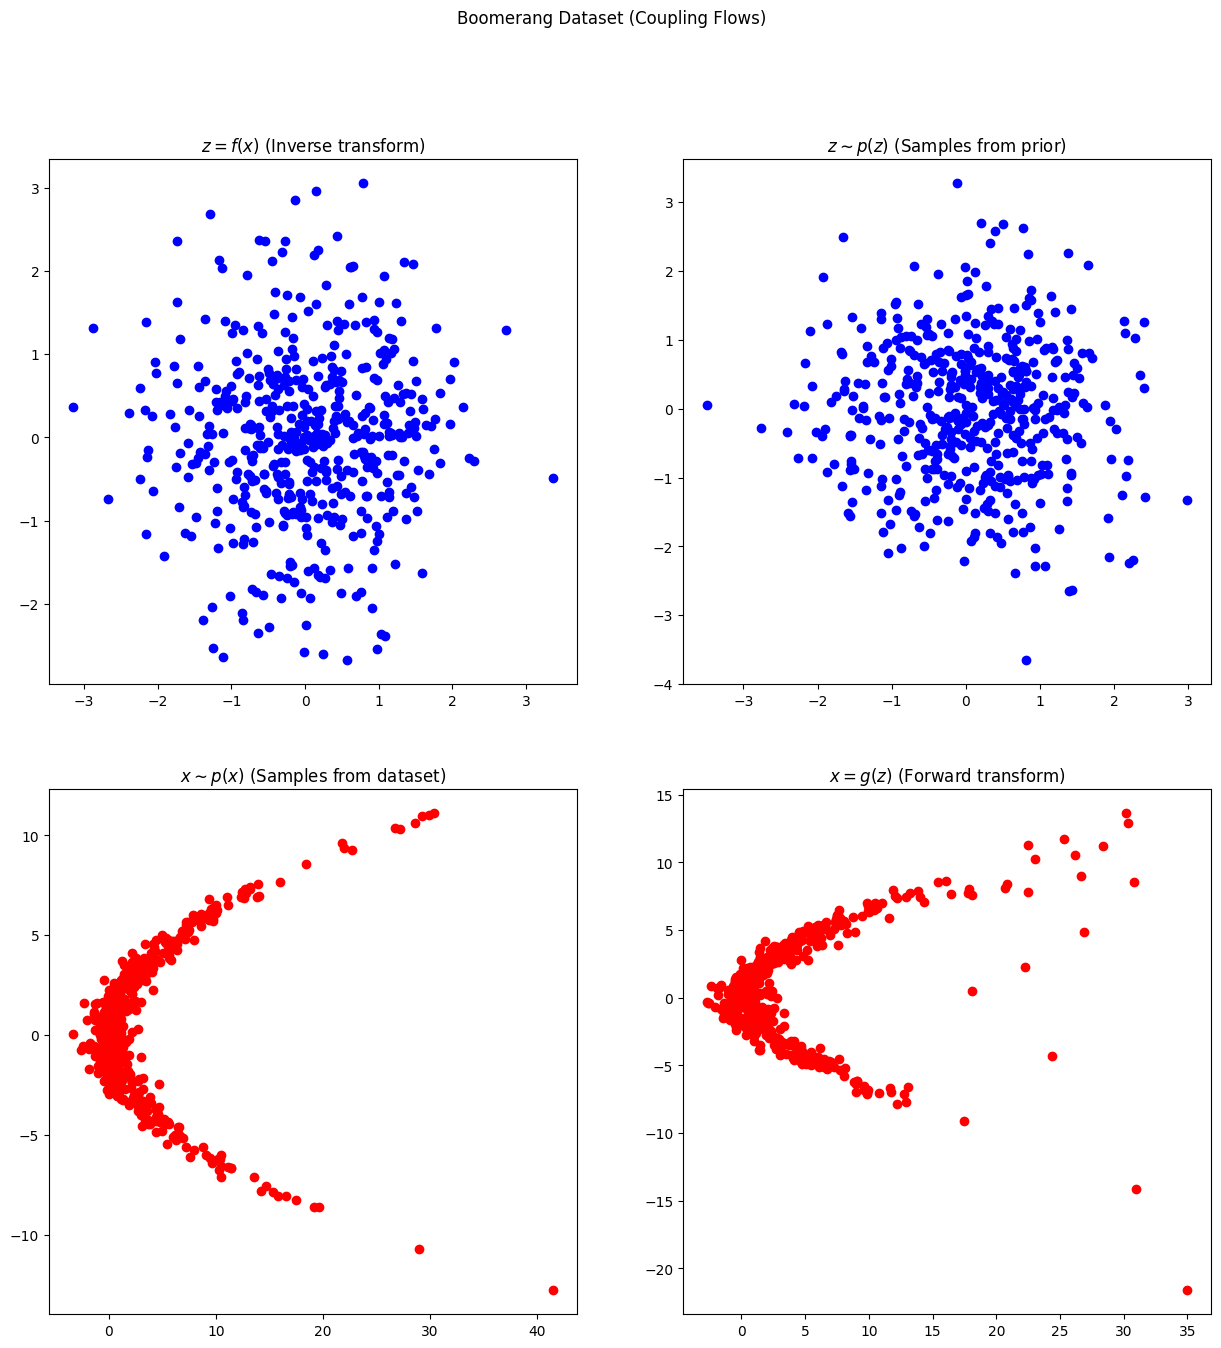

In [11]:
dim = 2
K = 5
batch_size= 64
epochs= 3000
lr = 0.0002
datasets = ['moons', "blobs", "boom"]
for dataset_name in datasets:
    real_NVP = CouplingFlow(dim=dim, K=K)
    dataset = Datasets(dataset_name)
    train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False)
    loss_func = TrainingLoss(dim=dim)
    optimiser = torch.optim.Adam(real_NVP.parameters(), lr=lr)
    for i in range(epochs):
        z_list = []
        x_list = []
        for step, data in enumerate(train_loader):
            #Pass batch through flow.
            optimiser.zero_grad()
            z0, loss = real_NVP.inverse(data)
            z_list.append(z0)
            x_list.append(data)
            # Training step. 
            loss.backward()
            optimiser.step()
    x_list_data = torch.cat(x_list, 0)
    z_list_inverse = torch.cat(z_list, 0)
    x_list_gen = []
    z_list_prior = []
    prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
    for i in range(500):
        sample_from_prior = real_NVP.base_distr.rsample()
        z_list_prior.append(sample_from_prior.detach().numpy())
        x = real_NVP(sample_from_prior.unsqueeze(0))
        x_list_gen.append(x.squeeze().detach().numpy())
    plt.scatter
    plt.scatter
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(dataset.name + " Dataset (Coupling Flows)")
    axs[0, 1].scatter(torch.Tensor(z_list_prior)[:,0], torch.Tensor(z_list_prior)[:,1], color="b")
    axs[0, 1].set_title('$z \sim p(z)$ (Samples from prior)')
    axs[1, 1].scatter(torch.Tensor(x_list_gen)[:,0], torch.Tensor(x_list_gen)[:,1], color="r")
    axs[1, 1].set_title('$x = g(z)$ (Forward transform)')
    axs[0, 0].scatter(torch.Tensor(z_list_inverse)[:,0].detach().numpy(), torch.Tensor(z_list_inverse)[:,1].detach().numpy(), color="b")
    axs[0, 0].set_title('$z = f(x)$ (Inverse transform)')
    axs[1, 0].scatter(torch.Tensor(x_list_data)[:,0].detach().numpy(), torch.Tensor(x_list_data)[:,1].detach().numpy(), color="r")
    axs[1, 0].set_title('$x \sim p(x)$ (Samples from dataset)')
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.savefig("figures/"+dataset.name + " Dataset (Coupling Flows).png")
    